In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/Dataset_Challenge_Dataset_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json


In [2]:
with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json','r') as f:
    raw_text = f.readlines()
df = pd.DataFrame([json.loads(i) for i in raw_text])

In [3]:
df.sample(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
40581,ZJVSwGvvGFvMz74D5wM5MQ,Salon Stylush,"4205 N Winfield Scott Plz, Ste 104",Scottsdale,AZ,85251,33.495813,-111.931976,5.0,10,1,"{'BusinessParking': '{'garage': False, 'street...","Beauty & Spas, Hair Salons",None
103559,R-c15Amg_tsGc5aYH1js6g,Accredited Pool Service,1676 Sabatini Dr,Henderson,NV,89052,35.971164,-115.113990,2.5,7,1,None,"Pool & Hot Tub Service, Shopping, Hot Tub & Po...","{'Monday': '8:0-16:30', 'Tuesday': '8:0-16:30'..."
102802,F8ggZW0dcJfRNQDZWfpDsg,T3 Therapeutic Massage Ahwatukee,"16815 S Desert Foothills Pkwy, ste 134",Phoenix,AZ,85048,33.294287,-112.062796,5.0,8,1,"{'ByAppointmentOnly': 'True', 'AcceptsInsuranc...","Alternative Medicine, Beauty & Spas, Massage T...","{'Wednesday': '9:0-20:0', 'Thursday': '12:0-20..."


Text(0, 0.5, 'Occurrence')

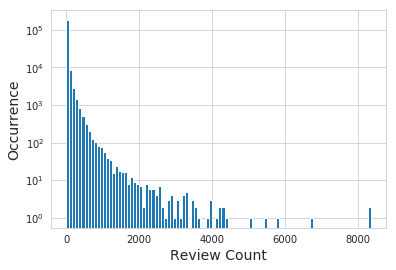

In [4]:
#绘制根据点评数量的直方图
sns.set_style('whitegrid')
fig,ax = plt.subplots()
ax.set_yscale('log')
df['review_count'].hist(ax=ax,bins=100)
ax.set_xlabel('Review Count',fontsize=14)
ax.set_ylabel('Occurrence',fontsize=14)

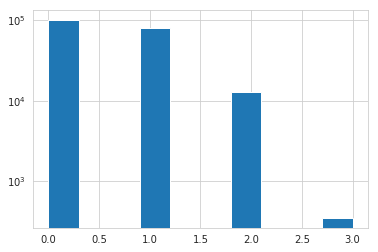

In [5]:
#点评数量跨越了若干个数量级，因此可能会对某些无监督学习方法早晨破坏，使用区间量化的方法把点评数分箱到许多箱子中。有两种分箱方法
#固定宽度分箱
fix_bin = np.floor(np.log10(df['review_count']))
fig,ax = plt.subplots()
ax.set_yscale('log')
fix_bin.hist(ax=ax,bins=10)

0.1     3.0
0.2     4.0
0.3     5.0
0.4     7.0
0.5     9.0
0.6    13.0
0.7    19.0
0.8    33.0
0.9    70.0
Name: review_count, dtype: float64


Text(0, 0.5, 'Occurrence')

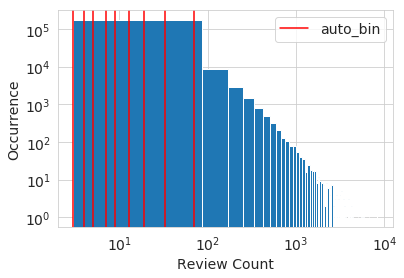

In [6]:
#自适应宽度分箱，#分位数分箱
auto_bin = df['review_count'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9])
print(auto_bin)
sns.set_style('whitegrid')
fig,ax = plt.subplots()
df['review_count'].hist(ax=ax,bins=100)
for pos in auto_bin:
    handle = plt.axvline(pos,color='r')
ax.legend([handle],['auto_bin'],fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count',fontsize=14)
ax.set_ylabel('Occurrence',fontsize=14)


Text(0, 0.5, 'Occurrence')

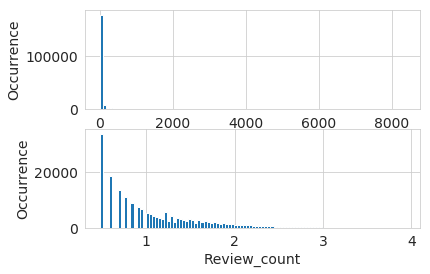

In [7]:
#重尾或者重头分布情况下使用对数函数压缩高值区间同时扩展低值区间
fig,(ax1,ax2) = plt.subplots(2,1)
df['review_count'].hist(ax=ax1,bins=100)
ax1.tick_params(labelsize=14)
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xlabel('Review_count',fontsize=14)
ax1.set_ylabel('Occurrence',fontsize=14)

log_review_count=np.log10(df['review_count'])
log_review_count.hist(ax=ax2,bins=100)
ax2.tick_params(labelsize=14)
#ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Review_count',fontsize=14)
ax2.set_ylabel('Occurrence',fontsize=14)

In [8]:
#使用对数变化后尝试通过点评数量预测商家的平均评分
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

df['log_review_count'] = np.log10(df['review_count']+1)
md = linear_model.LinearRegression()
scores_org = cross_val_score(md,df[['review_count']],df['stars'],cv=10)
scores_log = cross_val_score(md,df[['log_review_count']],df['stars'],cv=10)
print(scores_org.mean(),scores_org.std()*2)
print(scores_log.mean(),scores_log.std()*2)
#可以看到对于经过对数函数压缩的review_count可以有效提高R方分数，不过同时方差也略微增大

0.0015984695729691855 0.0009018947676662125
0.0040814022073620395 0.0014731172630962864


Text(0, 0.5, 'Averagne Star Ratting')

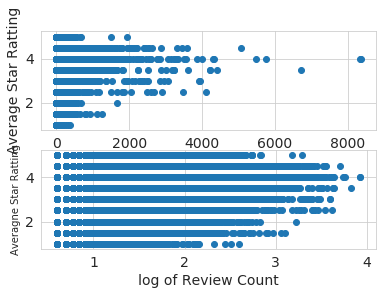

<Figure size 360x720 with 0 Axes>

In [9]:
#点评中输入和输出相关性能可视化（二维）
fig,(ax1,ax2) = plt.subplots(2,1)
fig=plt.figure(figsize=(5,10))
ax1.scatter(df['review_count'],df['stars'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Review Count',fontsize=14)
ax1.set_ylabel('Average Star Ratting',fontsize=14)
ax2.scatter(df['log_review_count'],df['stars'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log of Review Count',fontsize=14)
ax2.set_ylabel('Averagne Star Ratting')


In [10]:
#使用Box-Cox变化重新分布 点评数量
from scipy import stats
df['test_0'] = stats.boxcox(df['review_count'],lmbda=0)#lmbda=0 即为对数变化
df['test_1'],parm = stats.boxcox(df['review_count'])
print('最接近正态分布的labda=',parm)


最接近正态分布的labda= -0.37107910850437914


Text(0, 0.5, 'box-cox transformed counts histogram')

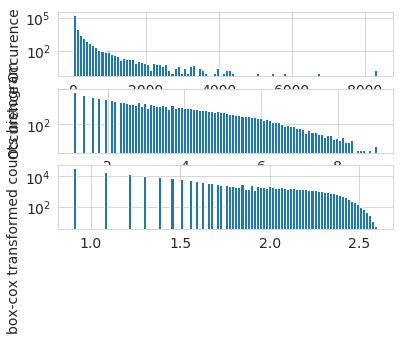

In [11]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1)
#未经过处理
df['review_count'].hist(ax=ax1,bins=100)
ax1.tick_params(labelsize=14)
ax1.set_yscale('log')
ax1.set_ylabel('Occurence',fontsize=14)

#对数处理
df['test_0'].hist(ax=ax2,bins=100)
ax2.tick_params(labelsize=14)
ax2.set_yscale('log')
ax2.set_ylabel('Occurence',fontsize=14)
ax2.set_xlabel('ln transformed counts histogram',fontsize=14)
#最优labda变化
df['test_1'].hist(ax=ax3,bins=100)
ax3.tick_params(labelsize=14)
ax3.set_yscale('log')
ax3.set_ylabel('box-cox transformed counts histogram',fontsize=14)

In [12]:
#我们再简单通过交叉验证对比一下
score0 = cross_val_score(md,df[['review_count']],df['stars'],cv=10)
score1 = cross_val_score(md,df[['test_0']],df['stars'],cv=10)
score2 = cross_val_score(md,df[['test_1']],df['stars'],cv=10)
print("mean",score0.mean(),score1.mean(),score2.mean())
print("std",score0.std(),score1.std(),score2.std())
#我们希望看到经过log变化或者box-cox变化后可以有更好的效果，目前来看log变化反而效果更好。

mean 0.0015984695729691855 0.0041498029035261785 0.004060974712943699
std 0.00045094738383310624 0.0007482462080137474 0.000776082829318992
